# Hack the news Datathon https://www.datasciencesociety.net/datathon/
## Team leopards 5th place task 1 and overall

The following code is a review of the code used for the task 1 of the 'Hack the News' Datathon by https://www.datasciencesociety.net/

Find here the dataset https://s3.us-east-2.amazonaws.com/propaganda-datathon/dataset/datasets-v5.zip


Find here the complete article https://www.datasciencesociety.net/datathon-hacknews-solution-leopards/


## Loading the dataset

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
plt.style.use('ggplot')
%matplotlib inline
seed=1234

In [2]:
# read the data from txt, tab separeted
df= pd.read_table('datasets-v3_1/task-1/task1.train.txt', header= None)

In [3]:
df.columns = ['text', 'id', 'label']
df.set_index('id', inplace= True)

In [4]:
df[:3]

,text,label
id,,
727600136,"Et tu, Rhody? A recent editorial in the Provi...",non-propaganda
731714618,A recent post in The Farmington Mirror — our t...,non-propaganda
731714635,"President Donald Trump, as he often does while...",non-propaganda


## Category Analysis

Text(0.5, 0, 'n of articles')

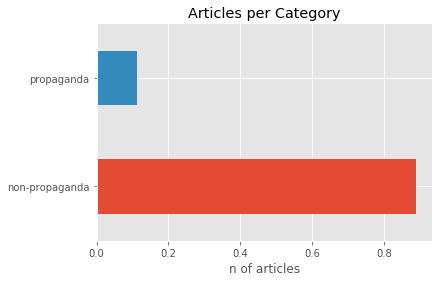

In [5]:
df['label'].value_counts(normalize= True).plot(kind='barh')
plt.title('Articles per Category')
plt.xlabel('n of articles')

In [6]:
# mapping 1 propaganda, 0 non propaganda
MAP= {'propaganda':1, 'non-propaganda':0}
df['cat']= df['label'].map(MAP)

In [7]:
def plot_n_len(ser):
    '''Given a Series containing text, isualize words number and count distribution per article.
    return total number of words'''
    results = set()
    ser.str.lower().str.split().apply(results.update)
    print(f'Total number of words: {len(results)}')
    l_art = ser.apply(lambda words: len(words.split(" ")))
    plt.figure(figsize=(8, 5))
    sns.boxplot(x= l_art, orient= 'h',)
    plt.title('Number of Words per Article')
    return len(results)

Total number of words: 562249


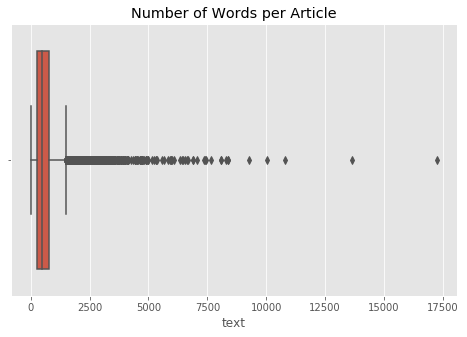

In [8]:
n_words1= plot_n_len(df['text'])

In [9]:
#check one of the longest article
df[(df['text'].apply(lambda words: len(words.split(" "))) >10000).values]['text'].iloc[1]

'Photo: FEMA Map Screengrab Image 1 of / 377 Caption Close  Image 1 of 377 Guadalupe County Guadalupe County Photo: FEMA Map Screengrab  Image 2 of 377 Caldwell County Caldwell County Photo: FEMA Map Screengrab  Image 3 of 377 Gonzales County Gonzales County Photo: FEMA Map Screengrab  Image 4 of 377 Hays County Hays County Photo: FEMA Map Screengrab  Image 5 of 377  Image 6 of 377 A tattered U.S. flag blows in the wind in the aftermath of Hurricane Harvey in Port Aransas, Texas on Sunday, Aug. 27, 2017. A tattered U.S. flag blows in the wind in the aftermath of Hurricane Harvey in Port Aransas, Texas on Sunday, Aug. 27, 2017. Photo: Kin Man Hui, San Antonio Express-News  Image 7 of 377 Texas National Guard soldiers arrive in Houston, Texas to aid citizens in heavily flooded areas from the storms of Hurricane Harvey. (Photos by Lt. Zachary West , 100th MPAD) Texas National Guard soldiers arrive in Houston, Texas to aid citizens in heavily flooded areas from the storms of Hurricane Harv

## Text Cleaning

In [10]:
# clean the text with apacy,
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def text_cleaner(text):
    text = re.sub("„", "'", text)    
    text = re.sub("’", "'", text)
    text = re.sub(r'[\n\t]', ' ', text)
    tokens = nlp(text, disable=['parser', 'ner'])
    tokens = [t.lemma_.lower().strip() for t in tokens if t.lemma_ != '-PRON-'
              and (t.is_punct or t.is_space or t.like_num or t.like_url) == False]
    tokens = [t for t in tokens if t not in STOP_WORDS and len(t)>2]
    tokens = ' '.join(tokens)

    return tokens

In [11]:
# check how much time is needed for 10 articles
%timeit df['text'].iloc[:10].apply(text_cleaner)

1.37 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# check the cleaning results
df['text'].iloc[:10].apply(text_cleaner)

id
727600136    rhody recent editorial providence journal cata...
731714618    recent post farmington mirror town version oni...
731714635    president donald trump respond natural disaste...
728627182    february black history month loom large black ...
728627443    snow heavy whip gust wind travel nearly imposs...
732126660    month sandy hook school shooting connecticut l...
728144791    major newspaper article donald trump describe ...
728605281    year start new york art dealer robert simon si...
731383701    president donald trump tumultuous administrati...
734075146    hartford edge future aetna cvs health corp. ch...
Name: text, dtype: object

In [13]:
# to be reactivated if needed
import pickle
'''
df['text_clean']= df['text'].apply(text_cleaner)
#dump to picle
df.to_pickle('cleaned.pkl')
'''

"\ndf['text_clean']= df['text'].apply(text_cleaner)\n#dump to picle\ndf.to_pickle('cleaned.pkl')\n"

In [14]:
df= pd.read_pickle('cleaned.pkl')

In [15]:
df[:3]

,text,label,cat,text_clean
id,,,,
727600136,"Et tu, Rhody? A recent editorial in the Provi...",non-propaganda,0,rhody recent editorial providence journal cata...
731714618,A recent post in The Farmington Mirror — our t...,non-propaganda,0,recent post farmington mirror town version oni...
731714635,"President Donald Trump, as he often does while...",non-propaganda,0,president donald trump respond natural disaste...


Total number of words: 169083


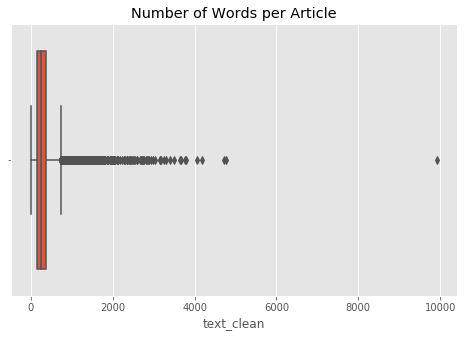

In [16]:
# Visualize words count distribution

n_word_cleaned= plot_n_len(df['text_clean'])

In [17]:
print('Uncleaned-cleaned text n of words difference', 
      round(((n_word_cleaned - n_words1) / n_words1), 2) *100, '%')

Uncleaned-cleaned text n of words difference -70.0 %


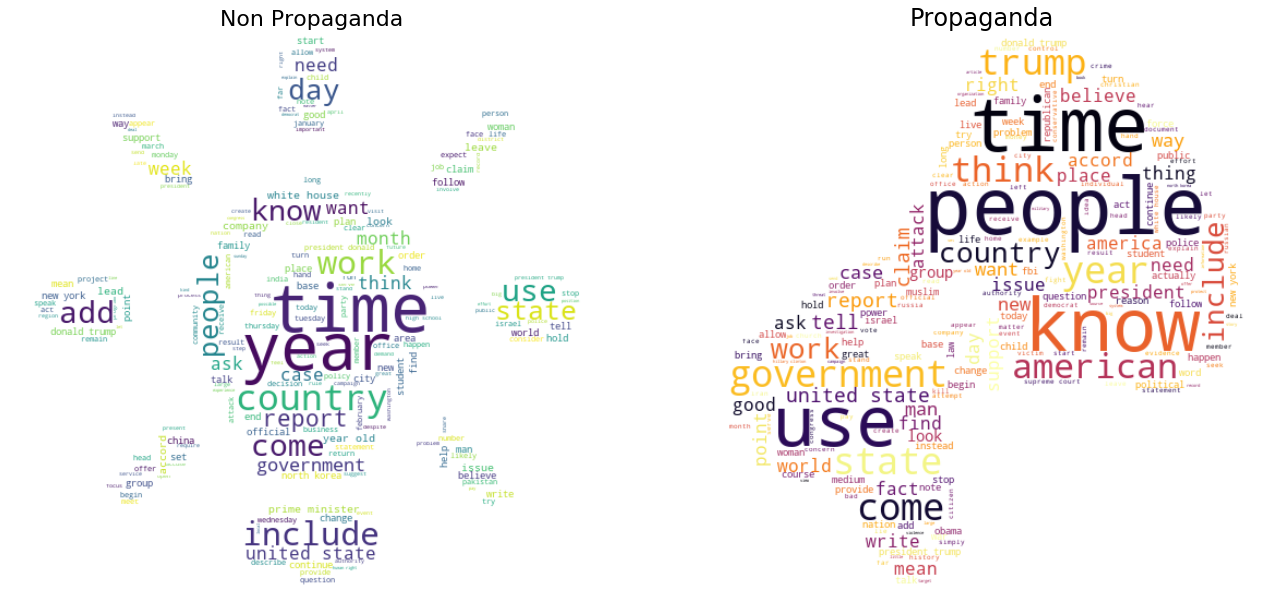

In [18]:
# creating 2 wordclouds
from PIL import Image
from wordcloud import WordCloud


plt.figure(1, figsize=(22, 14))
plt.subplot(121)
# mask non propaganda
mask = np.array(Image.open('nonpropaganda.jpg'))
words = pd.Series(df[df['label'] == 'non-propaganda']['text_clean'].tolist()).str.cat(sep=' ')
wordcloud = WordCloud(height= 400, max_words=200, background_color="white",
                      colormap='viridis', mask= mask, random_state= seed).generate(words)

plt.title('Non Propaganda', size= 22)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


plt.subplot(122)
# mask propaganda
mask = np.array(Image.open('propaganda.png'))
words = pd.Series(df[df['label'] == 'propaganda']['text_clean'].tolist()).str.cat(sep=' ')
wordcloud = WordCloud(height= 400, max_words=200, background_color="white",
                      colormap='inferno', mask= mask, random_state= seed).generate(words)
plt.title('Propaganda', size= 24)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Splitting the dataset, going on with the text analysis on the Train Data

In [19]:
from sklearn.model_selection import train_test_split
# splitting the data in test and train
X_train, X_test, y_train, y_test= train_test_split(df['text_clean'], df['cat'],
                                                   test_size= 0.25, random_state= 1234)

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

def chi2_word_plot(X, y, n= 50, max_features= 2500, stopwords= []):
    '''TfidfVectorizer and plot n most important chi2square max features after reducing dimesions,
    exluding stopwords'''

    

    # tf-idf vectorizer for sentence/topic/document modelling

    tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3),
                           stop_words= stopwords, min_df= 5, max_df=0.9)


    # Fit & Transform on train texts
    # Only transform on val & test texts

    X_tf = tvec.fit_transform(X).toarray()
    
    
    # Fitting Chi2
    chi2score = chi2(X_tf, y)[0]

    # Plot Important chi2square features after reducing dimesions

    ax = plt.figure(figsize=(16, 20))

    # Zip features names alongwith their scores & sort by chi2 score
    features_chi2scores = zip(tvec.get_feature_names(), chi2score)
    features_chi2scores_sorted = sorted(features_chi2scores, key=lambda x: x[1])

    # Top 20 Chi2 features
    topchi2 = list(zip(*features_chi2scores_sorted[-n:]))

    # Feature name & total length of the features to plot a horizontal barplot
    feature_names = topchi2[0]
    feature_score = topchi2[1]
    features_len = range(len(feature_score))

    plt.barh(features_len, feature_score, align='center', alpha=0.2)
    plt.plot(feature_score, features_len, '-o', markersize=5, alpha=0.8)

    plt.yticks(features_len, feature_names, fontsize=14)

    plt.xlabel('Chi2 $\chi^2$')
    plt.ylabel('Features')

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

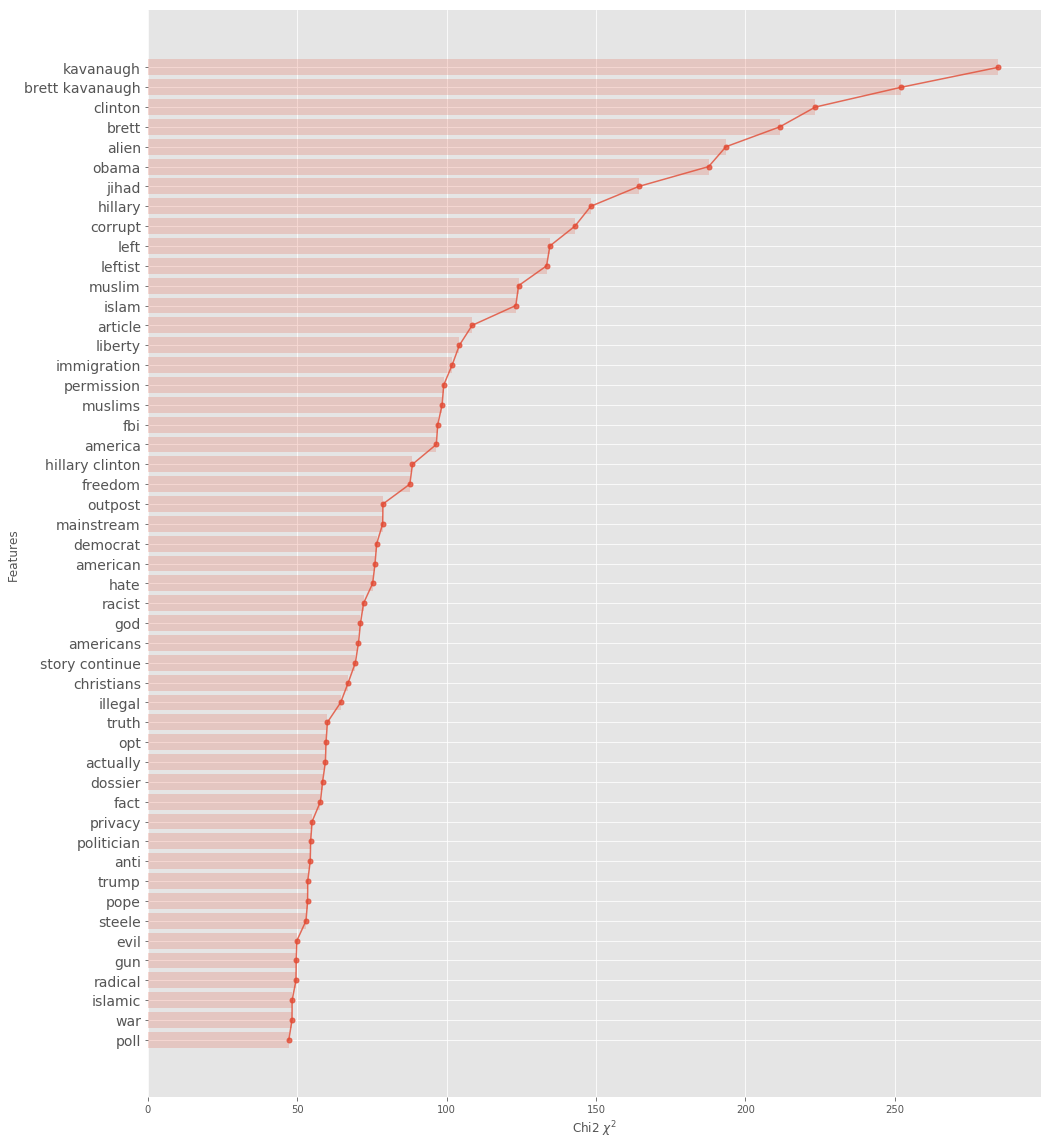

In [21]:
chi2_word_plot(X_train, y_train)

In [22]:
HTML('https://en.wikipedia.org/wiki/Brett_Kavanaugh')

As in the first 50 important chi2 square features I have many candidates name I will exclude them.
A candidate name, though, could help (in short term) to identify propaganda
I will remove brett kavanaugh also

### Exploration using Logistic Regression

In [23]:
# excluding names of candidates and kavanaugh
import requests
# get the list of all the candidates in a df
url= 'https://en.wikipedia.org/wiki/List_of_United_States_presidential_candidates_by_number_of_votes_received'
# use read_html to read the first table
candidates= pd.read_html(requests.get(url).content, skiprows= 1)[0][0] #[0][0] 1st table of the web 1st column

cand_set= []
candidates.str.lower().str.split(' ').apply(lambda x: [cand_set.append(x) for x in x])
cad_set= set(cand_set)
for n in ['brett', 'kavanaugh']:
    cand_set.append(n)

cand_set= set(cand_set)
cand_set

{'a.',
 'aaron',
 'abraham',
 'adams',
 'adlai',
 'al',
 'alf',
 'allan',
 'alson',
 'alton',
 'anderson',
 'andre',
 'andrew',
 'andrews',
 'b.',
 'badnarik',
 'baldwin',
 'barack',
 'barr',
 'barry',
 'bell',
 'benjamin',
 'benson',
 'bergland',
 'bidwell',
 'bill',
 'blaine',
 'bo',
 'bob',
 'breckinridge',
 'brett',
 'browne',
 'bryan',
 'buchanan',
 'buren',
 'bush',
 'butler',
 'c.',
 'calvin',
 'carter',
 'cass',
 'castle',
 'chafin',
 'charles',
 'christensen',
 'chuck',
 'clark',
 'claude',
 'clay',
 'cleveland',
 'clinton',
 'cobb',
 'coleman',
 'commoner',
 'coolidge',
 'cox',
 'cynthia',
 'darrell',
 'david',
 'davis',
 'debs',
 'dewey',
 'dewitt',
 'dole',
 'donald',
 'douglas',
 'dukakis',
 'dwight',
 'e.',
 'ed',
 'eisenhower',
 'eugene',
 'evan',
 'evans',
 'fillmore',
 'fisk',
 'follette',
 'ford',
 'foster',
 'frank',
 'franklin',
 'frémont',
 'fulani',
 'g.',
 'garfield',
 'gary',
 'george',
 'gerald',
 'goldwater',
 'gore',
 'grant',
 'greeley',
 'gritz',
 'grover',

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['st'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


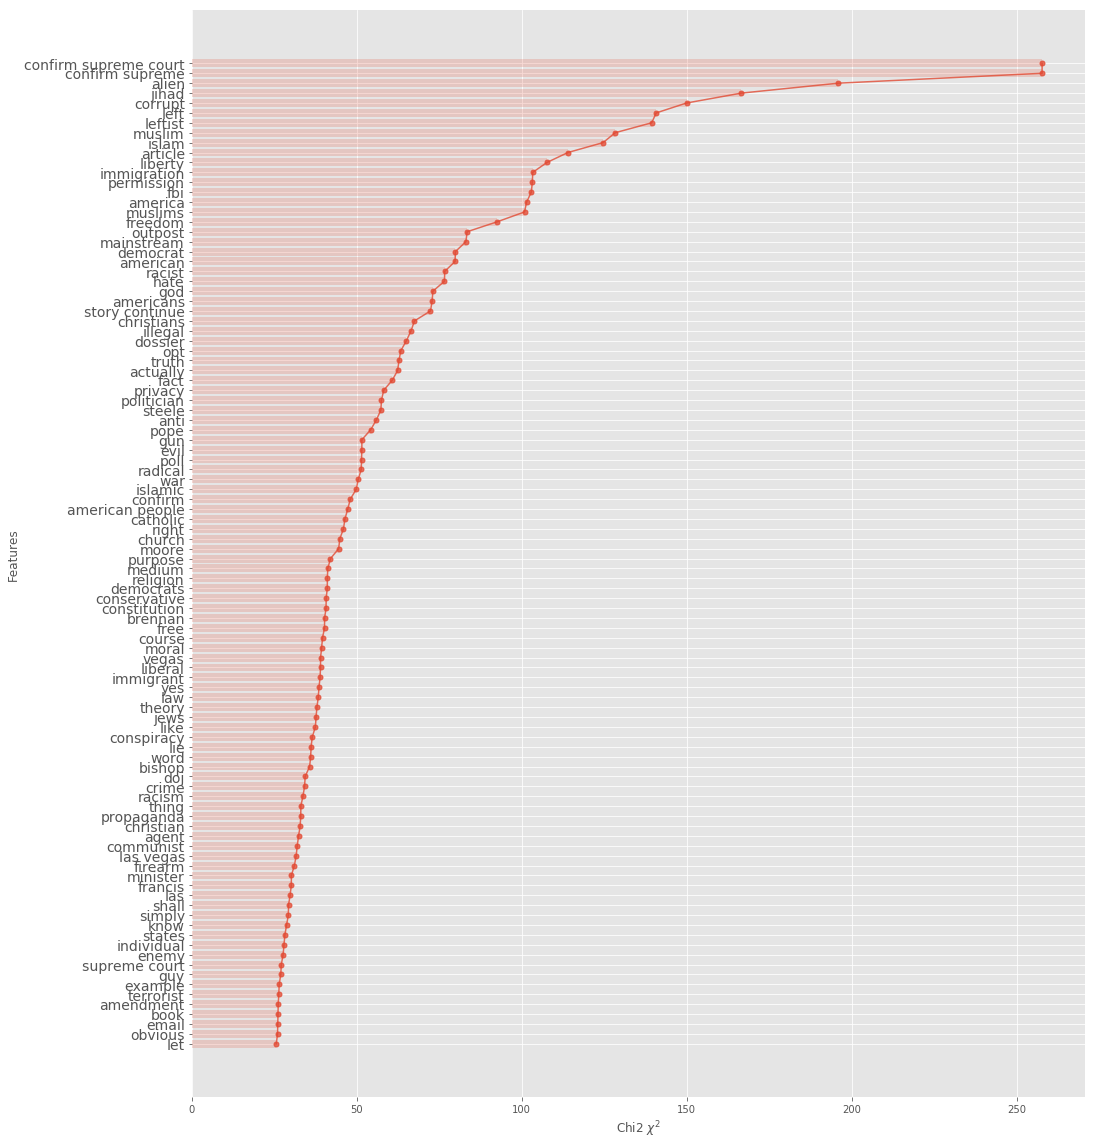

In [24]:
chi2_word_plot(X_train, y_train, n=100, stopwords= cand_set)

Selecting the best text rapresentation

In [25]:
max_features= int(1e5)

In [26]:
tvec= TfidfVectorizer(min_df=5, max_df= 0.8, lowercase= False,
                      max_features= max_features)
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs')

In [27]:
lr_param= dict(tvec__ngram_range= [(1,1), (1,2), (1,3)])

In [28]:
lr_clf= Pipeline([('tvec', tvec), ('clf', lr)])

In [29]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
lr_random= GridSearchCV(lr_clf, lr_param, scoring='f1', n_jobs = -1, cv= 3)

In [30]:
lr_random.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.8, max_features=100000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [31]:
print('Best score:', round(lr_random.best_score_,3), 'with', lr_random.best_params_)

Best score: 0.77 with {'tvec__ngram_range': (1, 3)}


The grid search and chi2 shows that (while in limited number) 3 grams (and 2) are important to distinguish between propaganda and non propaganda news

In [32]:
max_features= int(1e5)

In [33]:
tvec= TfidfVectorizer(min_df=5, lowercase= False, ngram_range= (1,3), 
                      max_features= max_features)
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs')

In [34]:
X_train_tfidf= tvec.fit_transform(X_train, y_train)
X_test_tfidf= tvec.transform(X_test)

In [35]:
# Calculating positive, negative matrices and summing along rows

vectorize_prop = tvec.transform(df[df['label'] == 'propaganda']['text_clean'])
vectorize_nonp = tvec.transform(df[df['label'] == 'non-propaganda']['text_clean'])

# Summing tf-idf values and remove single-dimensional entries from the shape of an array.
prop_tf_sq = np.squeeze(np.asarray(np.sum(vectorize_prop, axis=0)))
nprop_tf_sq = np.squeeze(np.asarray(np.sum(vectorize_nonp, axis=0)))

# tf-idf values saved in the dataframe
df_tfidf = pd.DataFrame([prop_tf_sq, nprop_tf_sq], columns=tvec.get_feature_names()).transpose()

# Sorting positive, negative sentiments

df_tfidf.columns = ['propaganda', 'non-propaganda']
df_tfidf['total'] = df_tfidf['propaganda'] + df_tfidf['non-propaganda']

df_tfidf.sort_values(by='total', ascending=False).iloc[:10]

,propaganda,non-propaganda,total
trump,135.928928,584.779314,720.708242
year,55.149663,495.109783,550.259446
president,68.847921,420.025726,488.873646
state,67.215323,405.884878,473.100201
people,82.882509,385.953076,468.835584
police,42.593928,422.242481,464.836409
government,63.865243,362.144548,426.009791
iran,39.335414,378.964132,418.299546
new,56.023240,354.850255,410.873494
school,39.527662,344.932610,384.460272


Text(0.5, 1.0, 'propaganda vs non-propaganda tokens frequency')

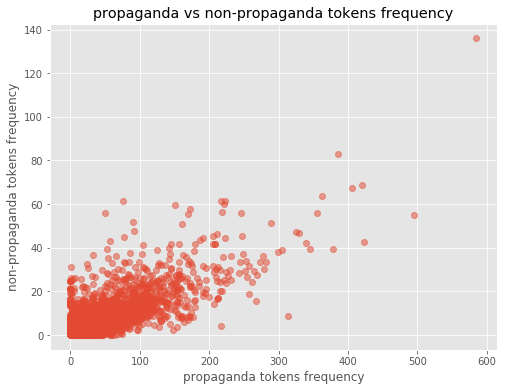

In [36]:
# Plot Fake & True News keyword frequency on X-axis, Y-axis respectively

plt.figure(figsize=(8, 6))
ax = sns.regplot(x='non-propaganda', y="propaganda", fit_reg=False,
                 scatter_kws={'alpha': 0.5}, data= df_tfidf)

plt.xlabel('propaganda tokens frequency')
plt.ylabel('non-propaganda tokens frequency')

plt.title('propaganda vs non-propaganda tokens frequency')

### TFIDF plot and most important features

## Testing logistic regression with the tuned vectorizer

In [38]:
max_features= int(1e5)

In [39]:
tvec= TfidfVectorizer(min_df=5, max_df= 0.6, lowercase= False, ngram_range= (1,3), 
                      max_features= max_features)
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs')

In [40]:
X_train_tfidf= tvec.fit_transform(X_train, y_train)
X_test_tfidf= tvec.transform(X_test)

In [41]:
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [42]:
y_pred= lr.predict(X_test_tfidf)

In [43]:
f1_score(y_test, y_pred)

0.773071778867588

### Hyperparameters Calibration

In [63]:
lr_param_grid = dict(
    C= [0.01, 0.1, 1, 10, 100, 1e3, 1e4],
    max_iter= [80,100, 120],
    tol= [0.0001, 0.0005, 0.001]
    )

In [64]:
lr_random_search= RandomizedSearchCV(lr, param_distributions= lr_param_grid,
                                    scoring= 'f1', n_iter=8, n_jobs=-1, cv=3)

In [65]:
lr_random_search.fit(X_train_tfidf, y_train)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'C': [0.01, 0.1, 1, 10, 100, 1000.0, 10000.0], 'max_iter': [80, 100, 120], 'tol': [0.0001, 0.0005, 0.001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [66]:
lr_random_search.best_params_

{'tol': 0.001, 'max_iter': 120, 'C': 100}

In [67]:
lr_random_search.best_score_

0.8298707898840219

Tuned logistic regression shows good f1 results

## test different calssifiers

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [60]:
classifiers = [
    ('SVM', SVC(kernel='linear')),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('Kneighbors', KNeighborsClassifier(2)),
    ('MLP', MLPClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('GradientBoosting', GradientBoostingClassifier())]
results=[]

for c in classifiers: 
    clf= Pipeline([('sel', SelectKBest(chi2, k= 500)),
                   ('clf', c[1])])
    print(f'Fitting {c[0]} classifier...')
    clf.fit(X_train_tfidf, y_train)
    print('Predicting...')
    y_pred= clf.predict(X_test_tfidf)
    results.append((c[0], f1_score(y_test, y_pred), y_pred))

Fitting SVM classifier...
Predicting...
Fitting DecisionTree classifier...
Predicting...
Fitting RandomForest classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicting...
Fitting Kneighbors classifier...
Predicting...
Fitting MLP classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Predicting...
Fitting AdaBoost classifier...
Predicting...
Fitting GradientBoosting classifier...
Predicting...


Text(0.5, 0, 'f1 score')

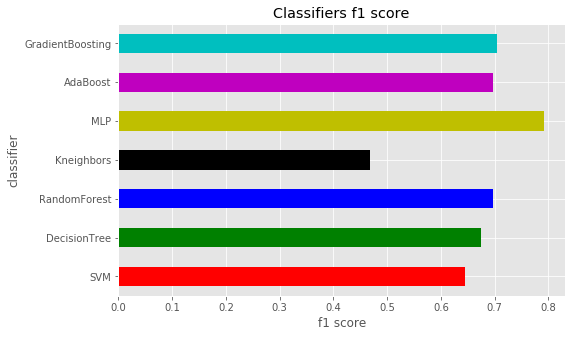

In [61]:
results= pd.DataFrame(results, columns=['classifier', 'f1_score', 'results'])
results[['classifier', 'f1_score']].set_index('classifier').plot(kind='barh',
                                                                 color= 'rgbkymc', legend=None, figsize=(8,5))
plt.title('Classifiers f1 score')
plt.xlabel('f1 score')

In [62]:
results[['classifier', 'f1_score']]

,classifier,f1_score
0,SVM,0.645619
1,DecisionTree,0.675542
2,RandomForest,0.697872
3,Kneighbors,0.467706
4,MLP,0.791136
5,AdaBoost,0.697175
6,GradientBoosting,0.705302


# MLP tuning

In [70]:
 mlp_k_f1score= {}
lr_k_f1score= {}
for k in np.arange(50, 1000, 100):
    mlp_pip= Pipeline([('sel', SelectKBest(chi2, k= k)), 
                       ('clf', MLPClassifier(solver= 'lbfgs'))])
    mlp_pip.fit(X_train_tfidf, y_train)
    y_pred= mlp_pip.predict(X_test_tfidf)
    mlp_k_f1score[k]= f1_score(y_test, y_pred)

Text(0.5, 0, 'n feature')

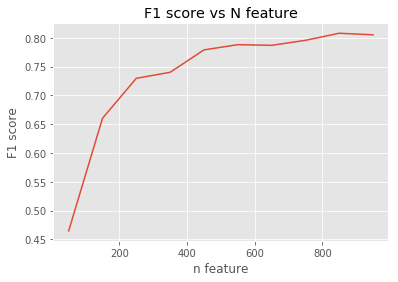

In [71]:
pd.Series(mlp_k_f1score).plot()
plt.title('F1 score vs N feature')
plt.ylabel('F1 score')
plt.xlabel('n feature')

In [130]:
mpl_param_grid= dict(clf__activation= ['tanh', 'relu', 'logistic'],
    clf__alpha=(0.0001, 0.001, 0.01, 0.05),
    clf__learning_rate= ['constant','adaptive'],
    clf__hidden_layer_sizes= [(50,50,50), (50,100,50), (100,)])

In [134]:
mlp_clf= Pipeline([('sel', SelectKBest(chi2, k= 800)),
                            ('clf', MLPClassifier(solver= 'lbfgs'))])

In [136]:
mlp_random_search= RandomizedSearchCV(mlp_clf, param_distributions= mpl_param_grid,
                                      scoring= 'f1', n_iter=10, n_jobs=-1, cv=3)

In [139]:
mlp_random_search.fit(X_vtrain, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('sel', SelectKBest(k=800, score_func=<function chi2 at 0x00000000092E9510>)), ('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       lea...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'clf__activation': ['tanh', 'relu', 'logistic'], 'clf__alpha': (0.0001, 0.001, 0.01, 0.05), 'clf__learning_rate': ['constant', 'adaptive'], 'clf__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [140]:
y_pred= mlp_random_search.predict(X_vtest)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [141]:
f1_score(y_test, y_pred)

0.7950169875424687

# Test Set

Predicion on the test set using Logistic Regression

In [142]:
# this code has been yoused to produced the clined pkl, to de-comment just if needed

'''
df_dev= pd.read_csv('task1.test.csv', usecols=[0,1], header= None)
df_dev.columns = ['text', 'id']
df_dev.set_index('id', inplace= True)
df_dev['text_clean']= df_dev['text'].apply(text_cleaner)
df_dev.to_pickle('cleaned_df.pkl')
'''


"\ndf_dev= pd.read_csv('task1.test.csv', usecols=[0,1], header= None)\ndf_dev.columns = ['text', 'id']\ndf_dev.set_index('id', inplace= True)\ndf_dev['text_clean']= df_dev['text'].apply(text_cleaner)\ndf_dev.to_pickle('cleaned_df.pkl')\n"

In [143]:
df_dev= pd.read_pickle('cleaned_df.pkl')
df_dev.set_index('id', inplace= True)

In [149]:
tvec= TfidfVectorizer(min_df=5, max_df= 0.9, lowercase= False, max_features= max_features, ngram_range= (1,3))
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs', tol= 0.001, max_iter= 120, C= 100)

In [ ]:
lr_clf.fit(df['text_clean'], df['cat'])
y_pred= lr_clf.predict(df_dev['text_clean'])

In [ ]:
MAP_R= {1: 'propaganda', 0: 'non-propaganda'}

predictions= pd.Series(y_pred).map(MAP_R).values

with open("finale-predictions.txt", "w") as fout:
    for article_id, prediction in zip(df_dev.index, predictions):
        fout.write("%s\t%s\n" % (article_id, prediction))